<h1> Pierre Arquillano<br>
Final Project<br>
BDA 600

In [1]:
import pandas as pd
import numpy as np
import pyLDAvis
import pyLDAvis.gensim_models
import re
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import datetime as dt
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

C:\Users\pierr\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
C:\Users\pierr\anaconda3\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


<h1> Data Import

In [2]:
#import data
df = pd.read_csv('TrumpStats.csv')

In [3]:
#drop NA's
df = df.dropna(subset=['status_published','status_message'])

In [4]:
#Determine Status Distribution
#Group By Status Type
groupedStatus = df.groupby(['status_type'])

#Get Count of each Status type
status = groupedStatus.size()
status_df = status.reset_index(name='count')

Text(0.5, 1.0, 'distribution of types of statuses')

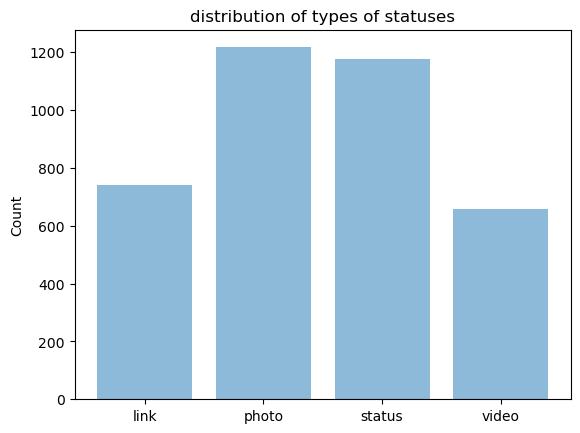

In [5]:
#Use charts (histogram/bar graph) to display the distribution of types of statuses (photo,video, link, and status).
plt.bar(status_df['status_type'], status_df['count'], align='center', alpha=0.5)
y_pos = np.arange(len(status_df['status_type']))
plt.xticks(y_pos,status_df['status_type'])
plt.ylabel('Count')
plt.title('distribution of types of statuses')

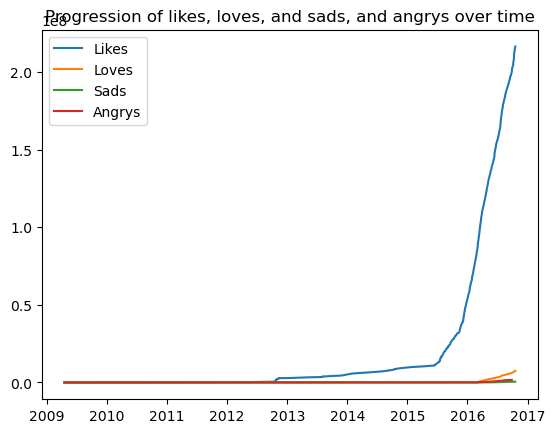

In [6]:
#Plot a chart showing the progression of likes, loves, and sads, and angrys over time.
df['status_published'] = pd.to_datetime(df['status_published'], format='%m/%d/%Y %H:%M:%S')
df_sorted = df.sort_values('status_published')
appen = 0
nLikes = []
nLoves = []
nSads = []
nAngrys = []
for x in df_sorted['num_likes']:
    appen += x
    nLikes.append(appen)
df_sorted['nLikes'] = nLikes
appen = 0
for x in df_sorted['num_loves']:
    appen += x
    nLoves.append(appen)    
df_sorted['nLoves'] = nLoves
appen = 0
for x in df_sorted['num_sads']:
    appen += x
    nSads.append(appen)
df_sorted['nSads'] = nSads
appen = 0
for x in df_sorted['num_angrys']:
    appen += x
    nAngrys.append(appen)
df_sorted['nAngrys'] = nAngrys
    

plt.plot(df_sorted['status_published'],df_sorted['nLikes'], label = 'Likes')
plt.plot(df_sorted['status_published'],df_sorted['nLoves'], label = 'Loves')
plt.plot(df_sorted['status_published'],df_sorted['nSads'], label = 'Sads')
plt.plot(df_sorted['status_published'],df_sorted['nAngrys'], label = 'Angrys')
plt.title('Progression of likes, loves, and sads, and angrys over time')
plt.legend()
plt.show()

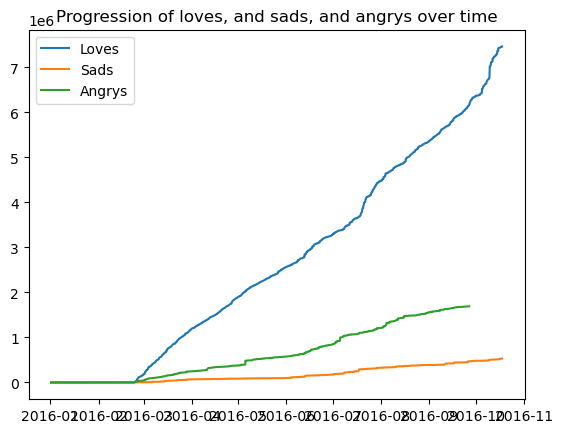

In [7]:
df_2016 = df_sorted[df_sorted['status_published'].dt.year >= 2016].copy()
appen = 0
nLoves = []
nSads = []
nAngrys = []
for x in df_2016['num_loves']:
    appen += x
    nLoves.append(appen)    
df_2016['nLoves'] = nLoves
appen = 0
for x in df_2016['num_sads']:
    appen += x
    nSads.append(appen)
df_2016['nSads'] = nSads
appen = 0
for x in df_2016['num_angrys']:
    appen += x
    nAngrys.append(appen)
df_2016['nAngrys'] = nAngrys
plt.plot(df_2016['status_published'],df_2016['nLoves'], label = 'Loves')
plt.plot(df_2016['status_published'],df_2016['nSads'], label = 'Sads')
plt.plot(df_2016['status_published'],df_2016['nAngrys'], label = 'Angrys')
plt.title('Progression of loves, and sads, and angrys over time')
plt.legend()
plt.show()

<h1>What are the top reactions expressed by Trump’s Facebook audience?

Text(0.5, 1.0, 'distribution of Reactions')

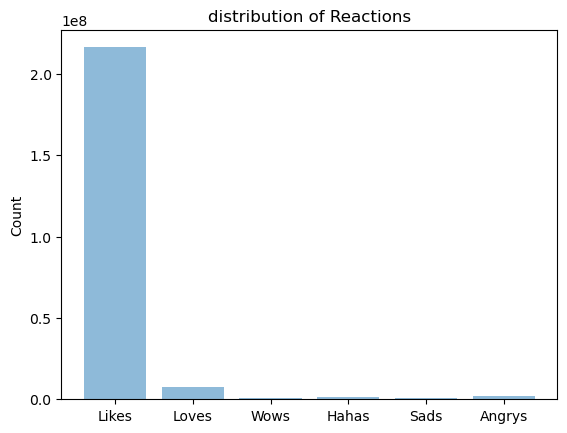

In [8]:
#Reactions(Loves,Wows,Hahas,Sads,Angrys) including Likes
rCounts = [df['num_likes'].sum(),df['num_loves'].sum(),df['num_wows'].sum(),df['num_hahas'].sum(),df['num_sads'].sum(),df['num_angrys'].sum()]
Reactions = ['Likes','Loves','Wows','Hahas','Sads','Angrys']
plt.bar(Reactions, rCounts, align='center', alpha=0.5)
y_Rpos = np.arange(len(Reactions))
plt.xticks(y_Rpos,Reactions)
plt.ylabel('Count')
plt.title('distribution of Reactions')

Text(0.5, 1.0, 'distribution of Reactions without Likes')

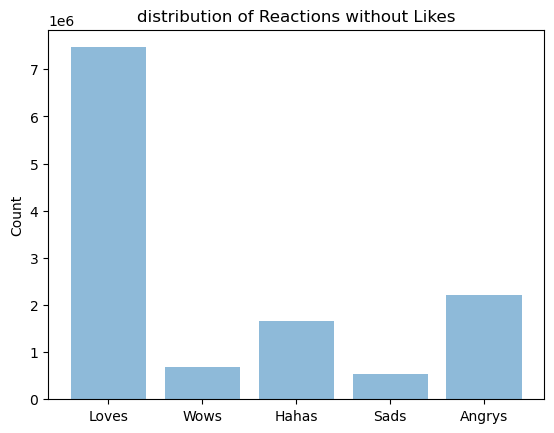

In [9]:
#Reactions(Loves,Wows,Hahas,Sads,Angrys) not including Likes
rCounts = [df['num_loves'].sum(),df['num_wows'].sum(),df['num_hahas'].sum(),df['num_sads'].sum(),df['num_angrys'].sum()]
Reactions = ['Loves','Wows','Hahas','Sads','Angrys']
plt.bar(Reactions, rCounts, align='center', alpha=0.5)
y_Rpos = np.arange(len(Reactions))
plt.xticks(y_Rpos,Reactions)
plt.ylabel('Count')
plt.title('distribution of Reactions without Likes')

<h1> Data Preprocessing and Cleaning

In [10]:
#remove photo number status messages
mask = df['status_message'].str.startswith('724')
df_filtered = df[~mask]

In [11]:
#Turn status messages into corpus
corpus = df_filtered['status_message'].tolist()

#tokenize corpus
tokenizer = RegexpTokenizer(r'\w+')
sw = set(stopwords.words('english'))

In [12]:
texts = []

#Remove stop words
for doc in corpus:
    words = re.findall(r'[A-Z]?[a-z]+', doc)
    docString = ' '.join(words)
    raw = docString.lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [token for token in tokens if token not in sw]
    texts.append(stopped_tokens)

In [13]:
dictionary = corpora.Dictionary(texts)

corpus_bow = [dictionary.doc2bow(text) for text in texts]

<h1> Model Creation

In [14]:
#determine optimal number of topics
ntopics = 0
co_score = 0
for x in range(4,15):
    lda_model = LdaModel(corpus_bow, num_topics=x, id2word=dictionary)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    cscore = coherence_model_lda.get_coherence()
    print(f'Topics:{x}\nCoherence Score:{cscore} ')
    if cscore > co_score:
        co_score = cscore
        ntopics = x

Topics:4
Coherence Score:0.2996232421474059 
Topics:5
Coherence Score:0.30255746245558346 
Topics:6
Coherence Score:0.30177577777661985 
Topics:7
Coherence Score:0.30819916072028947 
Topics:8
Coherence Score:0.3105219754956439 
Topics:9
Coherence Score:0.3012596843496242 
Topics:10
Coherence Score:0.2926293388376503 
Topics:11
Coherence Score:0.3075408392628415 
Topics:12
Coherence Score:0.318240061226253 
Topics:13
Coherence Score:0.302767608417672 
Topics:14
Coherence Score:0.33652614281369014 


In [15]:
lda_model = LdaModel(corpus = corpus_bow, num_topics=ntopics, id2word=dictionary)

In [16]:
#Display Top words per Topic
topics = lda_model.show_topics(num_topics=ntopics, num_words=10, formatted=False)

for topic in topics:
    print('Topic {}: {}'.format(topic[0], ' '.join([word[0] for word in topic[1]])))

Topic 0: trump thank support great watch america time new love make
Topic 1: america people make great american country want new president going
Topic 2: america great new make thank trump violence hillary police apprentice
Topic 3: trump america great hillary make would policies one change obama
Topic 4: trump great make america one cities president country people every
Topic 5: clinton hillary crooked people country trump state american jobs first
Topic 6: trump donald golf great america world com http businesses scotland
Topic 7: african people new going american work never country single heroes
Topic 8: trump support new get thank vote america great love going
Topic 9: trump great upon student benghazi country watch miss media america
Topic 10: thank great america support hurt love make trump evening largest
Topic 11: going american great trump every country new day much people
Topic 12: thank get november hillary clinton support trump great country america
Topic 13: trump hillary 

In [17]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(lda_model, corpus_bow, dictionary)
p

C:\Users\pierr\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.146031  0.051405       1        1  17.581055
1     -0.073082 -0.005819       2        1  12.058797
4     -0.046303 -0.082295       3        1   8.265545
6     -0.001955 -0.112829       4        1   8.138877
8      0.073238  0.020112       5        1   7.915190
11    -0.060515 -0.057872       6        1   7.887985
13    -0.049460  0.028735       7        1   6.814169
2      0.057926  0.028126       8        1   5.942809
0      0.080254 -0.031428       9        1   5.331270
3     -0.029418 -0.009290      10        1   4.905707
12     0.038956  0.147597      11        1   4.814531
7     -0.045229  0.067060      12        1   4.323541
9      0.067710 -0.048710      13        1   3.197019
10     0.133908  0.005209      14        1   2.823506, topic_info=         Term         Freq        Total Category  logprob  loglift
77    clinton   878.000000   878.000000  Default  30.0000  30.0000
83    hillary   900.000000   900.000000  Default  29.0000  29.0000
70      thank   503.000000   503.000000  Default  28.0000  28.0000
30      trump  1084.000000  1084.000000  Default  27.0000  27.0000
268   america   778.000000   778.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
448     obama     8.971697   265.826719  Topic14  -5.3895   0.1784
14       time     8.479748   326.389532  Topic14  -5.4459  -0.0832
1517  minutes     6.910910    38.763104  Topic14  -5.6505   1.8428
581      http     7.621395   141.011051  Topic14  -5.5526   0.6493
25        get     7.423023   319.368076  Topic14  -5.5790  -0.1946

[1008 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4259      4  0.831594     academy
848       4  0.938959      access
3265      3  0.928115   accolades
4084      4  0.974081  accomplish
1382      6  0.913977     achieve
...     ...       ...         ...
587       6  0.067570     youtube
587       8  0.135140     youtube
587       9  0.270280     youtube
587      14  0.405420     youtube
3533      7  0.811570        zone

[2906 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 5, 7, 9, 12, 14, 3, 1, 4, 13, 8, 10, 11])

In [18]:
#adding new column displaying topic for the document
ldaTopics = []
for x in range(len(corpus_bow)):
    DocTops = lda_model[corpus_bow[x]][0][0]
    ldaTopics.append(DocTops)
df_filtered['topic'] = ldaTopics

<h1>Can you tell if fans are particularly happy or upset about the topics? 

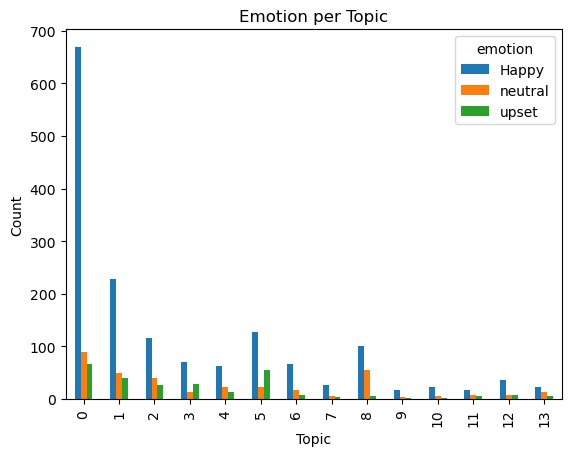

In [19]:
#create new df Tracking the count of emotions for each topic
df_filtered['status_published'] = pd.to_datetime(df_filtered['status_published'], format='%m/%d/%Y %H:%M:%S')
df_filt_2016 = df_filtered[df_filtered['status_published'].dt.year >= 2016].copy()
df_filt_2016['emotion'] = df_filt_2016.apply(lambda row: 'Happy' if row['num_loves']+row['num_hahas'] > row['num_sads']+row['num_angrys'] else ('upset' if row['num_loves']+row['num_hahas'] < row['num_sads']+row['num_angrys'] else 'neutral'), axis=1)

groupedEmotes = df_filt_2016.groupby(['topic','emotion'])
emotes = groupedEmotes.size()
emotes_df = emotes.reset_index(name='count')

# create a pivot table 
pivot_df = pd.pivot_table(emotes_df, index='topic', columns='emotion', values='count', aggfunc='sum')

# create the bar graph
pivot_df.plot(kind='bar')
plt.title('Emotion per Topic')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()

<h1>What are the themes (topics or top words) that generated a lot of shares?

Text(0.5, 1.0, 'distribution of Shares per Topic')

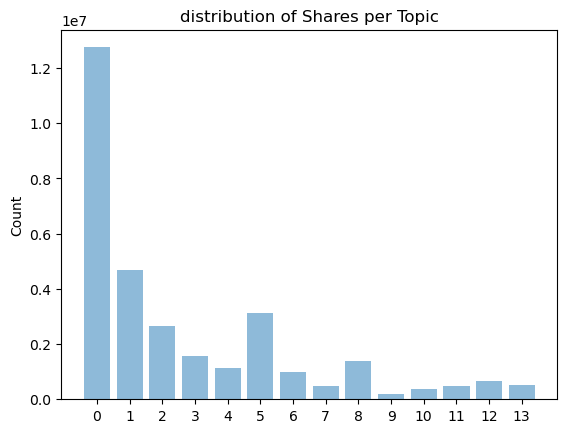

In [20]:
tot_Topic_Shares = []
list_Topics = []
for x in range(ntopics):
    df_temp = df_filtered[df_filtered['topic'] == x].copy()
    list_Topics.append(x)
    tot_Topic_Shares.append(df_temp['num_shares'].sum())
    
plt.bar(list_Topics, tot_Topic_Shares, align='center', alpha=0.5)
y_Tpos = np.arange(len(list_Topics))
plt.xticks(y_Tpos,list_Topics)
plt.ylabel('Count')
plt.title('distribution of Shares per Topic')

<p> This chart displays that Topic 0 has the most shares

,<h1>What are the themes (topics or top words) that generated a lot of num_reactions?

Text(0.5, 1.0, 'distribution of Reactions per Topic')

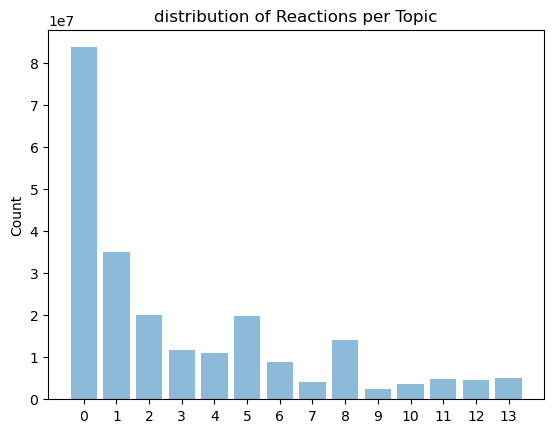

In [21]:
tot_Topic_Reactions = []
for x in range(ntopics):
    df_temp = df_filtered[df_filtered['topic'] == x].copy()
    tot_Topic_Reactions.append(df_temp['num_reactions'].sum())
    
plt.bar(list_Topics, tot_Topic_Reactions, align='center', alpha=0.5)
y_Tpos = np.arange(len(list_Topics))
plt.xticks(y_Tpos,list_Topics)
plt.ylabel('Count')
plt.title('distribution of Reactions per Topic')

<p> This chart displays that Topic 0 has the most shares, Followed by Topic 2 and Topic 1